# Mini project 1, group AM

## Table of content
<!-- [1. Data Preparation](#1.-Data-Preparation)  
[2. Analysis](#2.-Analysis)  
[3. Results](#3.-Results)  -->

[Imports](#imports)

[Part 1](#1)
- [1) Structural preprocessing](#structural-preprocessing)
   - [a) Skull-stripping](#a-skull-stripping)
   - [b) Segmentation](#b-segmentation)
- [2) Functional preprocessing](#functional-preprocessing)
   - [a) Concatenation](#a-concatenation)
   - [b) Motion correction](#b-motion-correction)
   - [c) Co-registration (bonus)](#c-co-registration-(bonus))
   - [d) Gaussian smoothing](#d-gaussian-smoothing)
- [3) Experimental design matrix](#experimental-design-matrix)
- [4) GLM analysis](#glm-analysis)
- [5) Activation maps](#activation-maps)
- [6) Atlas overlay](#atlas-overlay)

[Part 2 : Variant 3](#2)
- [1) K-means clustering](#2-1)
- [2) Selection of a number of clusters](#2-2)
- [3) Pairwise similarity](#2-3)

## Imports

In [1]:
%gui wx
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist


#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt
from fsl.wrappers import mcflirt

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json
import subprocess
import gc

Gtk-Message: 18:48:16.635: Failed to load module "canberra-gtk-module"


# Part 1

## 1) Structural preprocessing

### 1)a) Skull-stripping

In [2]:
anatomical_path = op.join("subject101410", "T1w", "T1w.nii.gz") #the original brain
subject_id = '101410'

In [3]:
derivatives = op.join("derivatives", "preprocessed_data", "subject_101410")
deriv_anat = op.join(derivatives, "anat")
deriv_func = op.join(derivatives, "func")

for d in (deriv_anat, deriv_func):
    os.makedirs(d, exist_ok=True)

print("Derivatives will be written to:", os.path.abspath(derivatives))

Derivatives will be written to: /data/derivatives/preprocessed_data/subject_101410


In [4]:
#bids_root   = "/data/NX-NSSP"  
#preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')
#deriv_root = op.join(bids_root, 'derivatives')

In [16]:
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

In [17]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(anatomical_path)


(ipykernel_launcher.py:496): Gdk-WARNING **: 17:28:20.218: gdkdrawable-x11.c:952 drawable is not a pixmap or window


In [5]:
def get_skull_stripped_anatomical(deriv_anat, anatomical_path, subject_id, robust=False):
    """
    Function to perform skull-stripping (removing the skull around the brain).
    This is a simple wrapper around the brain extraction tool (BET) in FSL's suite
    It assumes data to be in the BIDS format (which we will cover in the following weeks).
    The method also saves the brain mask which was used to extract the brain.

    The brain extraction is conducted only on the T1w of the participant.

    Parameters
    ----------
    subject_id: string
        Subject ID, the subject on which brain extraction should be conducted.
    robust: bool
        Whether to conduct robust center estimation with BET or not. Default is False.
    """
    # We perform here skull stripping (you'll learn more about it next week!).
    # For now all you need to do is that we remove the bones and flesh from the MRI to get the brain!
    betted_brain_path = op.join(deriv_anat, 'sub-{}_T1w'.format(subject_id))
    os.system('bet {} {} -m {}'.format(anatomical_path, betted_brain_path, '-R' if robust else ''))
    print("Done with BET.")

resulting_mask_path = op.join(deriv_anat, 'sub-101410_T1w_mask')
get_skull_stripped_anatomical(deriv_anat, anatomical_path, subject_id, robust=True)

Done with BET.


In [19]:
fsleyesDisplay.load(resulting_mask_path)

In [6]:
def apply_fsl_math_approach(img_path, mask_path, masked_img_path):
    os.system('fslmaths {} -mas {} {}'.format(img_path, mask_path, masked_img_path))
    
betted_brain_path = op.join(deriv_anat, 'sub-101410_T1w.nii.gz') # The brain without skull is in the derivatives folder
resulting_mask_path = op.join(deriv_anat, 'sub-101410_T1w_mask.nii.gz') # The mask to use

apply_fsl_math_approach(anatomical_path, resulting_mask_path, betted_brain_path)

In [21]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(betted_brain_path)

### 1)b) Segmentation

In [23]:
bet_path = op.join(deriv_anat, 'sub-101410_T1w')
fast_target = bet_path # Replace with either anatomical_path or bet_path (note: you can try both and decide which is more reasonable!)

[os.remove(f) for f in glob.glob(op.join(deriv_anat, '*fast*'))] # Just to clean the directory in between runs of the cell
segmentation_path = op.join(deriv_anat, 'sub-101410_T1w_fast')
fast(imgs=[fast_target], out=segmentation_path, n_classes=3)

{}

pve_0 in red : CSF \
pve_1 in green : grey matter \
pve_2 in blue : white matter

In [25]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(bet_path)
fsleyesDisplay.load(glob.glob(op.join(deriv_anat,'*pve_0*'))[0])
fsleyesDisplay.load(glob.glob(op.join(deriv_anat,'*pve_1*'))[0])
fsleyesDisplay.load(glob.glob(op.join(deriv_anat,'*pve_2*'))[0])
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[1]).cmap = 'Red'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[2]).cmap = 'Green'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[3]).cmap = 'Blue'

## 2) Functional preprocessing

### 2)a) Concatenation

In [7]:
# Create functional paths
functional_path_LR = op.join("subject101410", "fMRI", "tfMRI_MOTOR_LR", "tfMRI_MOTOR_LR.nii") 
functional_path_RL = op.join("subject101410", "fMRI", "tfMRI_MOTOR_RL", "tfMRI_MOTOR_RL.nii") 

print("Functional paths have been created")

Functional paths have been created


In [8]:
# Code to verify folder size
total_size = sum(os.path.getsize(os.path.join(deriv_func, f)) for f in os.listdir(deriv_func))
print(f"Remaining size in derivatives folder: {total_size / (1024**2):.2f} MB")


Remaining size in derivatives folder: 900.98 MB


In [9]:
###########################################
# Variance Normalisation - Run LR
###########################################
print("Normalizing variance for LR run")

# Calculate the variance for LR
variance_LR = subprocess.check_output(["fslstats", functional_path_LR, "-V"]).decode().split()[1]
print(f"Global variance for LR: {variance_LR}")

# Compute the scaling factor (1 / sqrt(variance))
scale_LR = 1 / (float(variance_LR) ** 0.5)
print(f"Scaling factor for LR: {scale_LR}")

# Apply scaling to normalize the variance
scaled_LR_path = os.path.join(deriv_func, "tfMRI_MOTOR_LR_varscaled.nii.gz")
subprocess.run(["fslmaths", functional_path_LR, "-mul", str(scale_LR), scaled_LR_path], check=True)
print(f"Saved normalized LR run: {scaled_LR_path}\n")

# Delete intermediary variables to free memory
del variance_LR, scale_LR
gc.collect()

###########################################
# Variance Normalisation - Run RL
###########################################
print("Normalizing variance for RL run")

# Calculate the variance for RL
variance_RL = subprocess.check_output(["fslstats", functional_path_RL, "-V"]).decode().split()[1]
print(f"Global variance for RL: {variance_RL}")

# Compute the scaling factor for RL (1 / sqrt(variance))
scale_RL = 1 / (float(variance_RL) ** 0.5)
print(f"Scaling factor for RL: {scale_RL}")

# Apply scaling to normalize the variance
scaled_RL_path = os.path.join(deriv_func, "tfMRI_MOTOR_RL_varscaled.nii.gz")
subprocess.run(["fslmaths", functional_path_RL, "-mul", str(scale_RL), scaled_RL_path], check=True)
print(f"Saved normalized RL run: {scaled_RL_path}\n")

# Delete intermediary variables to free memory
del variance_RL, scale_RL
gc.collect()

###########################################
# Concatenate the two runs
###########################################
print("Concatenating normalized runs...")

concat_path = os.path.join(deriv_func, f"sub-{subject_id}_motor_concat_varscaled.nii.gz")
subprocess.run(["fslmerge", "-t", concat_path, scaled_LR_path, scaled_RL_path], check=True)

print(f"Done! Final concatenated file: {concat_path}")

Normalizing variance for LR run
Global variance for LR: 519161344.000000
Scaling factor for LR: 4.388830677732065e-05
Saved normalized LR run: derivatives/preprocessed_data/subject_101410/func/tfMRI_MOTOR_LR_varscaled.nii.gz

Normalizing variance for RL run
Global variance for RL: 519202016.000000
Scaling factor for RL: 4.3886587735293315e-05
Saved normalized RL run: derivatives/preprocessed_data/subject_101410/func/tfMRI_MOTOR_RL_varscaled.nii.gz

Concatenating normalized runs...
Done! Final concatenated file: derivatives/preprocessed_data/subject_101410/func/sub-101410_motor_concat_varscaled.nii.gz


### 2)b) Motion correction

In [10]:
print("Starting the motion correction")
path_motioncorrected= op.join(deriv_func, "tfMRI_MOTOR_motioncorrected") # path to the motion corrected file
mcflirt(infile=concat_path, o=path_motioncorrected, plots=True, report=True, dof=6, mats=True)
print("Motor corrected")

# Display result
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(concat_path)
fsleyesDisplay.load(path_motioncorrected)
print("Motion corrected done")

Starting the motion correction


Processed data will be saved as derivatives/preprocessed_data/subject_101410/func/tfMRI_MOTOR_motioncorrected

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [284] to 8 mm pixels
Registering volumes ... [285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][315][316][317][318][319][320][321][322][323][324][325][326][327][328][329][330][331][332][333][334][335][336][337][338][339][340][341][342][343][344][345][346][347][348][349][350][351][352][353][354][355][356][357][358][359][360][361][362][363][364][365][366][367][368][369][370][371][372][373][374][375][376][377][378][379][380][381][382][383][384][385][386][387][388][389][390][391][392][393][394][395][396][397][398][399][400][401][402][403][404][405][406][407][408][409][410][411][412][413][414][415][416][417][418][419][420][421][422][423][424][425][42

refnum = 284
Original_refvol = -1


Registering volumes ... [285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][315][316][317][318][319][320][321][322][323][324][325][326][327][328][329][330][331][332][333][334][335][336][337][338][339][340][341][342][343][344][345][346][347][348][349][350][351][352][353][354][355][356][357][358][359][360][361][362][363][364][365][366][367][368][369][370][371][372][373][374][375][376][377][378][379][380][381][382][383][384][385][386][387][388][389][390][391][392][393][394][395][396][397][398][399][400][401][402][403][404][405][406][407][408][409][410][411][412][413][414][415][416][417][418][419][420][421][422][423][424][425][426][427][428][429][430][431][432][433][434][435][436][437][438][439][440][441][442][443][444][445][446][447][448][449][450][451][452][453][454][455][456][457][458][459][460][461][462][463][464][465][466][467][468][469][470][471][472][473][474][475][476][477][478][479][

Motor corrected


NameError: name 'fsleyesDisplay' is not defined

In [32]:
# # Cell to run if save is not possible anymore

# import shutil
# import os

# folder_to_clear = "derivatives/preprocessed_data/subject_101410"
# if os.path.exists(folder_to_clear):
    # shutil.rmtree(folder_to_clear)
    # print("Dossier supprimé pour libérer de l'espace.")

Dossier supprimé pour libérer de l'espace.


# In order to determine how many in how many images the subject moves more than what is tolerated, we can run the cell below

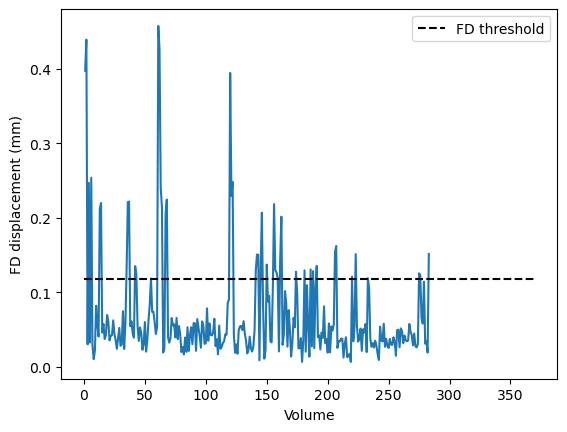

Indices of frames of LR motion above threshold: [1, 2, 4, 6, 13, 14, 35, 36, 37, 42, 43, 55, 61, 62, 63, 64, 67, 68, 120, 121, 122, 141, 142, 143, 145, 146, 150, 156, 157, 158, 159, 161, 162, 174, 181, 186, 188, 191, 206, 207, 220, 223, 233, 275, 276, 283]


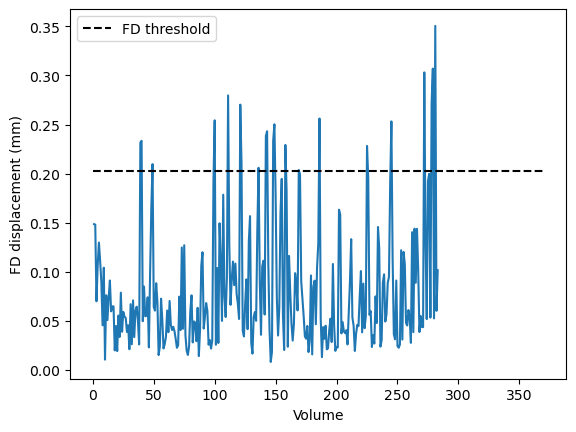

Indices of frames of RL motion above threshold: [39, 40, 49, 100, 111, 121, 122, 136, 142, 143, 148, 149, 158, 169, 186, 225, 245, 272, 278, 279, 281]


In [47]:
import matplotlib.pyplot as plt

lr_par_path = op.join(deriv_func, 'tfMRI_MOTOR_LR_motioncorrected.par')
rl_par_path = op.join(deriv_func, 'tfMRI_MOTOR_RL_motioncorrected.par')

def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

mot_params_LR = load_mot_params_fsl_6_dof(lr_par_path)
mot_params_LR

mot_params_RL = load_mot_params_fsl_6_dof(rl_par_path)
mot_params_RL

def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]

    rotation_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    
    convert_rot_to_arc = rotation_params*50                                    # transform from angle to arc of circle for a radius of 50mm, normal used values are 50 or 90 mm
    translation_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = convert_rot_to_arc.abs().sum(axis=1) + translation_params.abs().sum(axis=1)
    return fd

fd_LR = compute_FD_power(mot_params_LR).to_numpy()
threshold_LR = np.quantile(fd_LR,0.75) + 1.5*(np.quantile(fd_LR,0.75) - np.quantile(fd_LR,0.25))

#%matplotlib inline
plt.plot(list(range(1, fd_LR.size+1)), fd_LR)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold_LR, 0, 370,colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()

print(f"Indices of frames of LR motion above threshold: {(np.where(fd_LR > threshold_LR)[0] + 1).tolist()}")

fd_RL = compute_FD_power(mot_params_RL).to_numpy()
threshold_RL = np.quantile(fd_RL,0.75) + 1.5*(np.quantile(fd_RL,0.75) - np.quantile(fd_RL,0.25))

plt.plot(list(range(1, fd_RL.size+1)), fd_RL)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold_RL, 0, 370,colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()

print(f"Indices of frames of RL motion above threshold: {(np.where(fd_RL > threshold_RL)[0] + 1).tolist()}")

### 2)c) Co-registration (bonus)

### 2)d) Gaussian smoothing

## 3) Experimental design matrix

In [29]:
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nilearn.plotting import plot_design_matrix
from nilearn.datasets import fetch_atlas_aal
from nilearn.plotting import plot_stat_map
from IPython.display import display
from nilearn.image import mean_img
import matplotlib.pyplot as plt
from nilearn import plotting
import nibabel as nib
import numpy as np

In [14]:
events_path = '/data/subject101410/fMRI/tfMRI_MOTOR_LR/events_LR.csv'

events = pd.read_csv(op.join(events_path), sep=',')

print("Events Table")
pd.set_option('display.float_format', '{:,.2f}'.format)
display(events.head(11))

Events Table


,onset,duration,condition
0,0.00,8.00,NaN
1,8.00,3.00,cue
2,11.00,12.00,rh
3,23.00,3.00,cue
4,26.00,12.00,lf
5,38.00,3.00,cue
6,41.00,12.00,t
7,53.00,3.00,cue
8,56.00,12.00,rf
9,68.00,3.00,cue


done with parameters
Design Matrix


/opt/conda/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:198: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn(


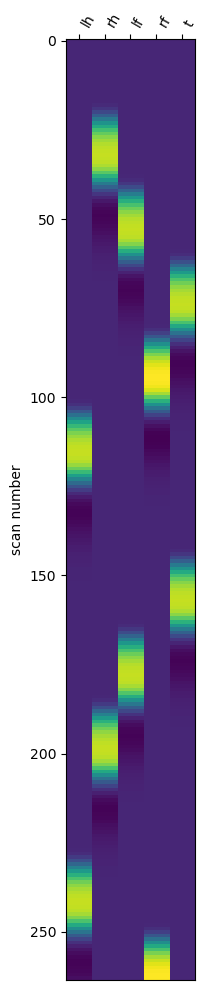

In [15]:
events.rename(columns={'condition': 'trial_type'}, inplace=True)
img = nib.load('derivatives/preprocessed_data/subject_101410/func/sub-101410_motor_concat_varscaled.nii.gz')
TR = img.header.get_zooms()[3]   # repetition time
last_scan = int(np.ceil(events['onset'].max() / TR)) + 1 
img_trimmed = img.slicer[:, :, :, :last_scan]
frame_times = np.arange(last_scan) * TR  # time vector for each volume

print('done with parameters')

design_matrix = make_first_level_design_matrix(
    frame_times,
    events,
    hrf_model='spm',
    drift_model='cosine',
    high_pass=0.01)

cols_to_keep = ['lh', 'rh', 'lf', 'rf', 't']  
design_matrix_filtered = design_matrix[cols_to_keep]

print('Design Matrix')
plot_design_matrix(design_matrix_filtered)
plt.show()


## 4) GLM analysis

In [20]:
from nilearn import image, plotting
mask_img = image.load_img(resulting_mask_path)
mask_epi = image.resample_to_img(mask_img, img, interpolation='nearest')

print("Mask resampled shape:", mask_epi.shape)
print("Affine match:", np.allclose(mask_epi.affine, img.affine))

Mask resampled shape: (91, 109, 91)
Affine match: True


In [21]:
first_level_model = FirstLevelModel(
    t_r=0.72,
    noise_model='ar1',
    standardize=False,
    hrf_model='spm',
    drift_model='cosine',   # or None if you don't want drift correction
    high_pass=.01
)
contrast = 'lh + rh - lf - rf'

# Fit the model to our design and data
fmri_glm = first_level_model.fit(img, events)



/opt/conda/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:198: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/nilearn/glm/first_level/first_level.py:707: UserWarning: Mean values of 0 observed. The data have probably been centered.Scaling might not work as expected
  Y, _ = mean_scaling(Y, self.signal_scaling)


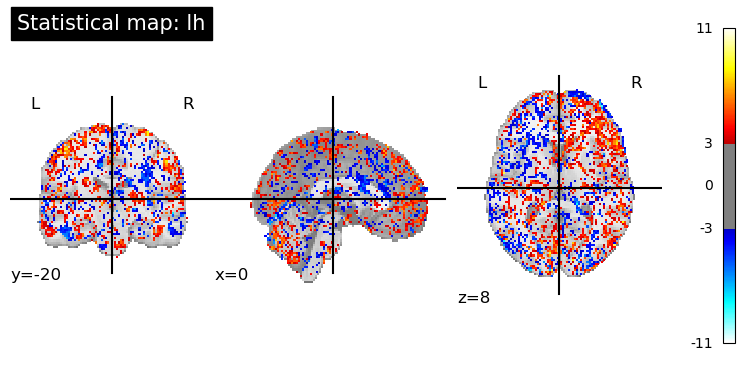

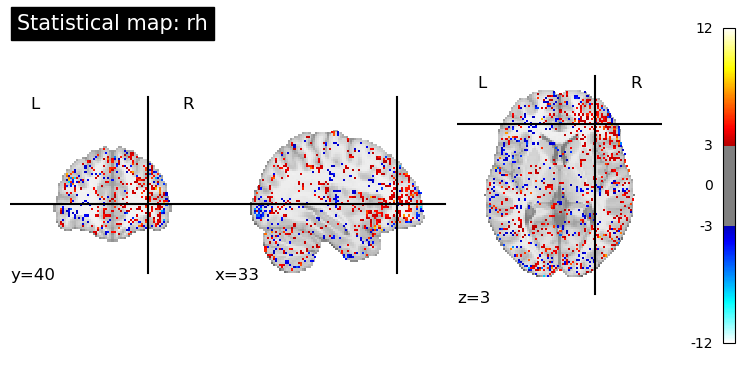

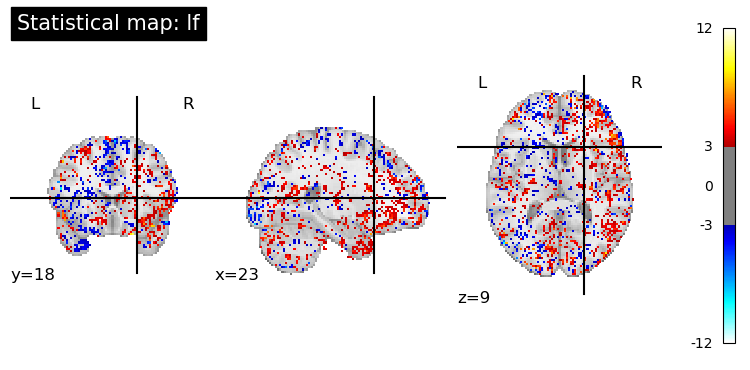

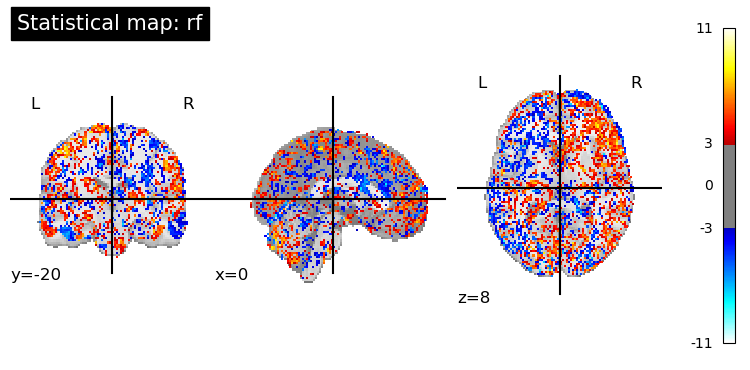

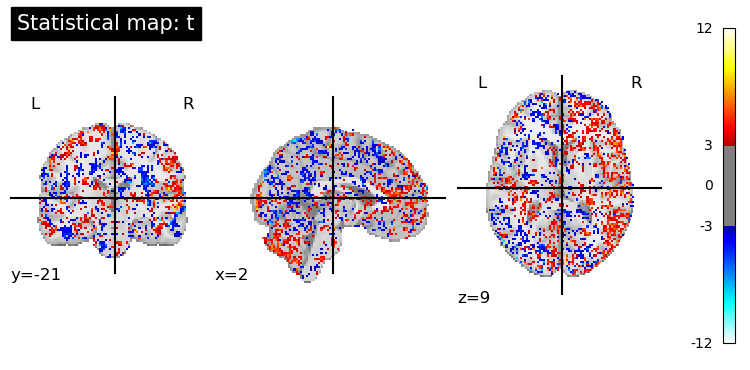

In [22]:
# Compute and plot t-map for each regressor and run
for reg in cols_to_keep:
    t_map = fmri_glm.compute_contrast(reg, output_type='stat')
    plotting.plot_stat_map(
        t_map,
        threshold=3.0,
        display_mode='ortho',
        title=f'Statistical map: {reg}'
    )

# Comments on t-map

## 5) Activation maps

Index(['cue', 'fixation', 'lf', 'lh', 'rf', 'rh', 't', 'drift_1', 'drift_2',
       'drift_3', 'drift_4', 'drift_5', 'drift_6', 'drift_7', 'drift_8',
       'constant'],
      dtype='object')


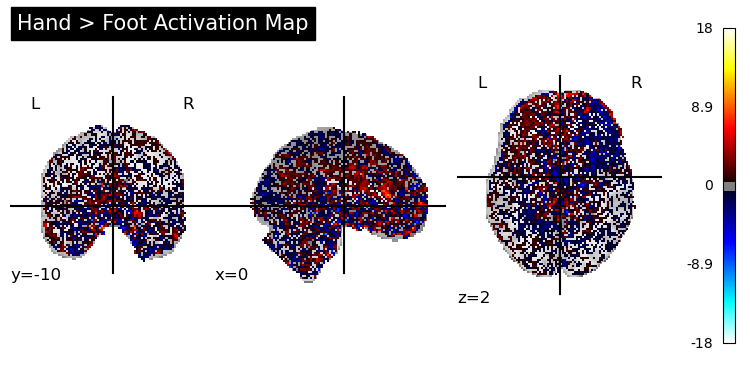

In [23]:
print(fmri_glm.design_matrices_[0].columns)

contrast = 'lh + rh - lf - rf'

activation_map = fmri_glm.compute_contrast(contrast, output_type='effect_size')

from nilearn import plotting
plotting.plot_stat_map(
    activation_map,
    threshold=0.5,        
    display_mode='ortho',
    title='Hand > Foot Activation Map'
)

#nib.save(activation_map, 'activation_map_hand_vs_foot.nii.gz')

## 6) Atlas overlay

hi
loading...
resampling is running...
resampling is done


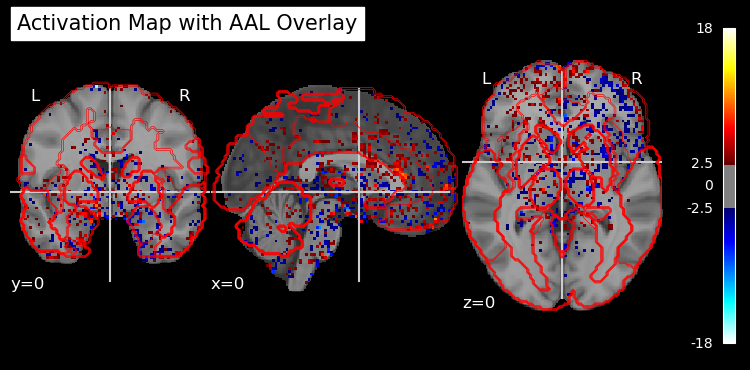

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting, image
from nilearn.datasets import fetch_atlas_aal, load_mni152_template
print('hi')
atlas = fetch_atlas_aal()
print('loading...')
bg = load_mni152_template()

# Resample atlas to activation map space
print('resampling is running...')
atlas_resampled = image.resample_to_img(atlas.maps, activation_map, interpolation='nearest')
print('resampling is done')

display = plotting.plot_stat_map(
    activation_map,
    bg_img=bg,
    threshold=2.5,
    display_mode='ortho',
    cut_coords=(0, 0, 0),
    title='Activation Map with AAL Overlay'
)

# Add the entire atlas as a single contour (fast)
display.add_contours(atlas_resampled, colors='red', linewidths=0.5)


# Part 2 : Variant 3
## 1) K-means clustering

In [40]:
# fMRI_path = '/data/NX-NSSP/subject101410/fMRI'
# func_path_LR = op.join(fMRI_path, 'tfMRI_MOTOR_LR') 
# func_path_RL = op.join(fMRI_path, 'tfMRI_MOTOR_RL') 

img = nib.load('derivatives/preprocessed_data/subject_101410/func/sub-101410_motor_concat_varscaled.nii.gz')
#Loading data
# img = nib.load(op.join(func_path_LR,'tfMRI_MOTOR_LR.nii'))
affine = img.affine
data = np.asanyarray(img.dataobj)
print(data.shape)


(91, 109, 91, 568)


In [34]:
#Preprocessing

# Make variables:
# 'vol_shape' for shape of volumes
# 'n_vols' for number of volumes
# YOUR CODE HERE
vol_shape = data.shape[:3]
n_vols    = data.shape[3]

# YOUR CODE HERE
# Note: In our case the background is encoded as 0 
# you can consider that the first volume's background 
# voxels are the same as all following volumes

slice_non_background = data[..., 0] != 0
# Vectorize : Taking only non-zero voxels into a vector 
# (NOTE: that the order is important)
samples = data[slice_non_background, :]

# Calculate the mean across columns
spatial_means = samples.mean(axis=1, keepdims=True)   # shape: (n_vols, 1)

# Row means copied n_vols times so that we substract for each timepoint the spatial mean
row_means = np.repeat(spatial_means, samples.shape[1], axis=1) # shape: (n_vols, n_voxels)

# Subtract the means for each row, put the result into X
X_kmeans = samples - row_means

# Verify that the spatial mean behaves as expected after substraction
print("Mean after centering (should be ~0):", np.mean(X_kmeans, axis=1))


Mean after centering (should be ~0): [ 0.0000000e+00 -3.3580081e-09  0.0000000e+00 ...  0.0000000e+00
 -5.8765144e-09 -3.7777590e-09]


In [36]:
print(samples.shape)

(228516, 568)


In [37]:
X_kmeans.shape

(228516, 568)

In [35]:
from sklearn.cluster import KMeans

max_nb_clusters = 10
avg_dist_samples = []
for nb_cluster in range(1, max_nb_clusters):
    kmeans = KMeans(n_clusters=nb_cluster, random_state=0, n_init="auto").fit(X_kmeans.T)
    avg_dist_samples.append(kmeans.inertia_)

## 2) Selection of a number of clusters

In [22]:
import matplotlib.pyplot as plt

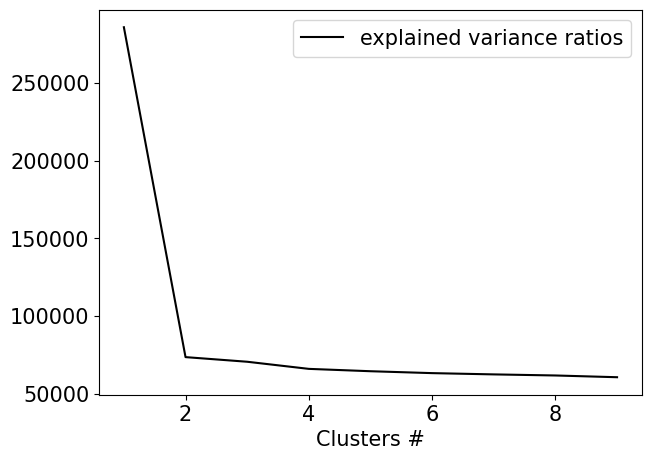

In [38]:
fig, ax = plt.subplots(1, figsize=(7,5))

ax.plot(np.arange(1, len(avg_dist_samples)+1), avg_dist_samples, label='explained variance ratios', c='k')

ax.set_xlabel('Clusters #', size=15)
ax.legend(prop={'size':15})
ax.tick_params(axis='both', which='major', labelsize=15)

In [41]:
# YOUR CODE HERE

nb_clusters = 2 # The number of clusters you want
kmeans = KMeans(n_clusters=nb_cluster, random_state=0, n_init="auto").fit(X_kmeans.T)

kmeans_clusters = [] # List of spatial components (you should have in the list volumes)
for i in range(nb_clusters):
    centroid_3d = np.zeros(vol_shape)         # full 3D shape
    centroid_3d[slice_non_background] = kmeans.cluster_centers_[i]
    kmeans_clusters.append(centroid_3d)

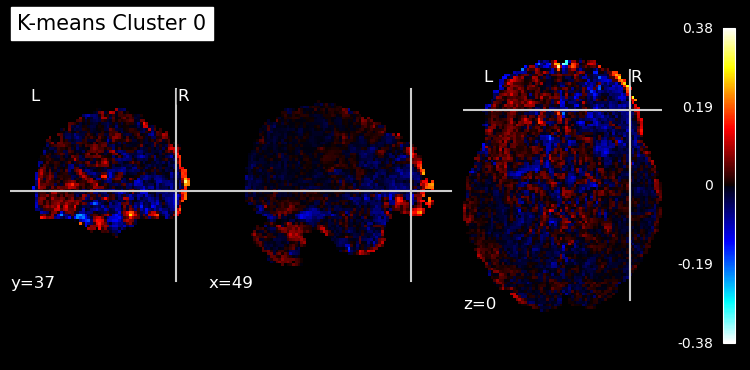

In [42]:
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
mean_img_ = mean_img(img)
visual_idx = 0
plot_stat_map(nib.Nifti1Image(kmeans_clusters[visual_idx], affine), bg_img=mean_img_, threshold=0,
               cut_coords=[49,37,00], black_bg=True,
              title=f'K-means Cluster {visual_idx}')

plt.show()

Cluster 1
Cluster 2


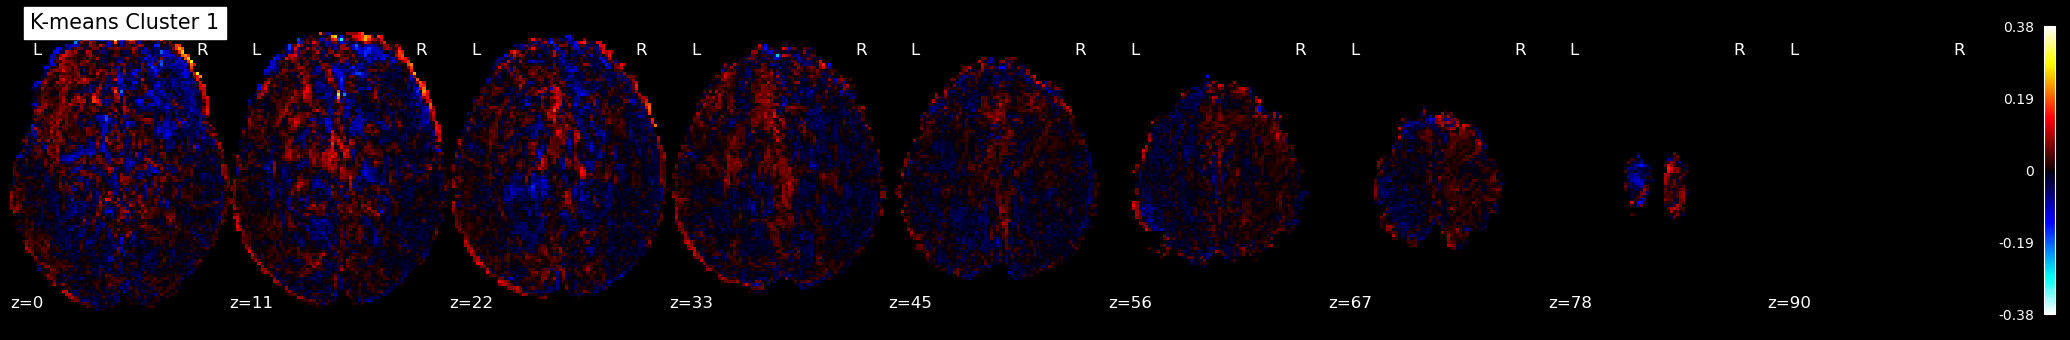

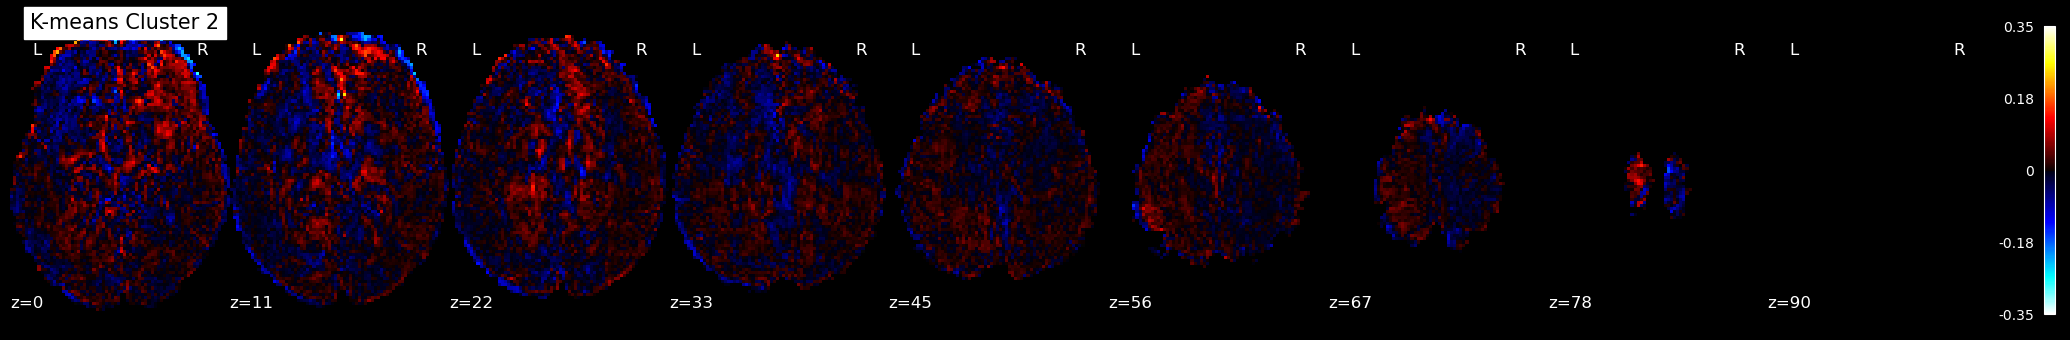

In [43]:
mean_img_ = mean_img(img)
zmax = vol_shape[2] - 1
cut_coords = list(np.linspace(0, zmax, 9, dtype=int))  # 9 axial slices

for i, centroid in enumerate(kmeans_clusters):
    print(f"Cluster {i+1}")
    plot_stat_map(
        nib.Nifti1Image(centroid, affine),
        bg_img=mean_img_,
        display_mode='z',
        cut_coords=cut_coords,
        threshold=0,
        colorbar=True,
        black_bg=True,
        title=f"K-means Cluster {i+1}"
    )

## 3) Pairwise similarity

In [44]:
nb_clusters = 5
kmeans = KMeans(n_clusters=nb_clusters, random_state=0, n_init="auto").fit(X_kmeans)


In [45]:
from scipy.stats import pearsonr

# cluster_centers_: shape (5, n_voxels)
C = kmeans.cluster_centers_

m = 5
sim = np.zeros((m, m))

for i in range(m):
    for j in range(m):
        sim[i, j] = pearsonr(C[i], C[j])[0]  # correlation coefficient

print("Similarity matrix (Pearson):")
print(np.round(sim, 3))


Similarity matrix (Pearson):
[[ 1.     0.81  -0.785  0.828 -0.797]
 [ 0.81   1.    -0.999  0.999 -1.   ]
 [-0.785 -0.999  1.    -0.997  1.   ]
 [ 0.828  0.999 -0.997  1.    -0.998]
 [-0.797 -1.     1.    -0.998  1.   ]]


# END